In [4]:
import numpy as np #general library, will come in handy later
import pandas as pd #another nice library for storing matrices, it rely's on numpy

import matplotlib.pyplot as plt #this library is for graphing things

#stuff for pre-processing
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso #These libraries have the necessary models
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score # a cheat for cross_validation

# Part a

First we load the data into memory. We can see that there are 11 variables in the data set and 10 dependent variables. 

## Calculating the number of observations


* There are 6 continuous variables i.e. income, Limit, Rating, Cards, Age, Education are continuous.

* We must also conisder the square of these for 6 more terms.

* There are 4 binary variables. Gender, student, married are binary and take 2 values and ethnicity can take 3 values. Thus, we must consider 5 dummy variables.

* There are 11 choose 2 = 55 interactions between all of these terms.


In total, I count 72 terms (Without the intercept). Clearly we would be overfitting if we included all of these predictors in our model.

There were many ways to set up the data. But, when setting up dummy variables it is easy to have 'collinearity' This means that 2 of your columns have the exact same values (or a linear combinition of eachother). When this happens, your coefficients will be very small. You should avoid this on future assignments



## Preprocessing libraries

There are a few useful functions to do the pre-processing. You did not need to use them, but they do exist. After the fact, I realize many of you did not know this and I should have included this in the hints.

For creating dummies you can use:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

Additionally, you can use the following to generate the interactions:

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [11]:
#load data
df = pd.read_csv('credit.csv')
nobs = df.count()['Balance']

print 'Number of observations: %s'%nobs

#set up dependent variable
y = df['Balance']

#set up predictor variables and their squares
continuous = df[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education']]
continuous_sq = np.array(continuous)**2

#set up the dummy variables
dummy = df[['Gender', 'Student' , 'Married', 'Ethnicity']]
dummy = pd.get_dummies(dummy,  drop_first=True) #Note I drop the first dummy to avoid collinearity

#merge dataframe
raw_characs = pd.merge(continuous, dummy, left_index=True, right_index=True)

#create all the interaction terms, the 'include_bias' is an intercept
interactions = PolynomialFeatures(interaction_only = True, include_bias = False).fit_transform(raw_characs)

#join columns
X = np.concatenate((continuous_sq,interactions),axis=1)

print 'Number of predictors: %s'%X.shape[1]

Number of observations: 400
Number of predictors: 72


# Part b

Below I fit the Lasso to the data set up in part a

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html


In [12]:
#fit the lasso to it, notice the second parameter is 0
#why do you think that is?
lasso = Lasso(alpha=.5) #note that alpha corresponds to lambda
lasso.fit(X, y)
print(lasso.coef_)
print(lasso.intercept_)

[ 3.57615455e-02  1.54890712e-05 -2.38701805e-03  1.37606136e+00
 -7.79643370e-03 -2.35078506e-01 -2.50132643e+00  9.31890403e-02
  1.23603379e-01  0.00000000e+00  1.57921207e+00  1.91708251e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -1.83888966e-03 -3.57083121e-03 -1.26306605e-01
  2.56903604e-02 -5.25278654e-02  6.53193822e-01 -2.42117500e+00
 -1.77477286e-01  7.69473526e-01  6.64823998e-01  3.71337448e-04
 -3.16926799e-03 -2.63821311e-04 -6.17165092e-04 -2.75389034e-02
  9.99173356e-02 -1.25203062e-02 -1.97500091e-02  1.33839223e-02
  7.70639610e-02 -3.68850171e-03  1.66197826e-02  2.73097444e-01
 -2.35699717e-01  1.84372367e-01  1.68592554e-01 -3.40609256e-01
  9.14540196e-03 -6.95809827e-02 -5.66611047e+00  9.63795545e+00
 -0.00000000e+00 -0.00000000e+00  5.19125137e+00 -1.26091123e-02
 -2.11618193e-01  4.90220919e-01  8.38213759e-02  6.39540392e-01
 -1.28320482e-01  2.29265801e+00  7.72346886e+00  2.16080897e-02
 -2.22883439e+00  2.86179

# Part c

I use the following function to calculate mean squared error. Implementing something similiar is not hard

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

In [15]:
#prepare fitted data to compare using MSE function

fitted_y = lasso.predict(X)
print'MSE: %s'%mean_squared_error(y, fitted_y)

MSE: 2713.976858251182


# Part d

Below I calcualte the cross-validated MSE.

For more on $k$-fold cross validation you can read the discussion on page 181 of the textbook

In [23]:
CV = []

for i in range(5):
    #compute start/end of fold
    start_index = (nobs/5)*i
    end_index = (nobs/5)*(i+1)
    
    #partition data
    X_test =  X[start_index:end_index]
    y_test = y[start_index:end_index]
    
    X_train = np.concatenate( (X[0:start_index],X[end_index:]) )
    y_train = np.concatenate( (y[0:start_index],y[end_index:]) )
          
    #estimate model
    l = Lasso(alpha=.5)
    l.fit(X_train,y_train)
    fitted_y = l.predict(X_test)
    
    CV.append(mean_squared_error(y_test, fitted_y))
    print 'CV Fold %s: %s \n'%((i+1), CV[i])
    
print 'Mean CV: %s'%(np.array(CV).sum()/5)

CV Fold 1: 3058.2058551388445 

CV Fold 2: 4786.382287358859 

CV Fold 3: 4267.441165389353 

CV Fold 4: 4252.2117876857255 

CV Fold 5: 4360.013302927697 

Mean CV: 4144.850879700096


If you wanted to reuse the code above for the rest of the assignment to do the cross validation, I would recommend defining a function that takes `X`, `y` and `cv` as arguments

You could have also used the folowing function to do the cross validation. It gives us the same answer. From here on out, I will be using this function (for reasons realted to numpy arrays, it runs faster than my code).

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [28]:
CV_MSE = -cross_val_score(lasso ,X,y,cv=5, scoring='neg_mean_squared_error')

print CV_MSE

[-3058.20585514 -4786.38228736 -4267.44116539 -4252.21178769
 -4360.01330293]


# Part E

The cross validated MSE is higher as expected. If you train the data using the same observations that you test with, you over fit.

# Part f

You can find more information about the Lasso with cross validation here

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

In [44]:
#first we use scipy's function to learn the optimal lambda
lambda_values = np.array(range(0,1000,5)) # create a grid

#fit model using grid
lass_cv = LassoCV(cv=5, alphas=lambda_values)
lass_cv.fit(X, y)

print 'Optimal Lambda: %s'%lass_cv.alpha_
fitted_y_cv = lass_cv.predict(X)



Optimal Lambda: 5
Optimal CV: 3973.882712457094


Below I create the loop, There is an error from including $\lambda = 0$

/home/erichschulman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/erichschulman/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/erichschulman/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)


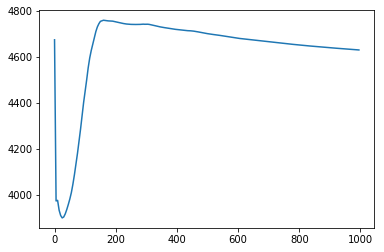

In [45]:
#iteratively fit model and create a graph
CV = []

for lamb in lambda_values:
    l = Lasso(alpha=lamb)
    l.fit(X, y)
    CV_i = -cross_val_score(l ,X,y,cv=5, scoring='neg_mean_squared_error').mean()
    CV.append(CV_i)
    
#graph result
plt.plot(lambda_values, CV)

# Part G

Results

In [54]:
#use the optimal lambda, to calculate a CV score
optimal_lasso = Lasso(alpha=lass_cv.alpha_)

optimal_cv = -cross_val_score(optimal_lasso,X,y,cv=5, scoring='neg_mean_squared_error')
print '------------------------------------'
print 'Optimal CV (by fold)'
print '------------------------------------'
print pd.DataFrame(optimal_cv)
print '------------------------------------'
print 'Optimal CV mean'
print '------------------------------------'
print optimal_cv.mean()
print '------------------------------------'
print 'Optimal coefficients'
print '------------------------------------'
print pd.DataFrame(lass_cv.coef_.reshape(18,4))
print '------------------------------------'
print 'Optimal intercept'
print '------------------------------------'
print (lass_cv.intercept_)


------------------------------------
Optimal CV (by fold)
------------------------------------
             0
0  3095.661316
1  4763.120499
2  4129.510981
3  3776.295843
4  4104.824924
------------------------------------
Optimal CV mean
------------------------------------
3973.882712457094
------------------------------------
Optimal coefficients
------------------------------------
           0         1         2         3
0   0.036731  0.000015 -0.002569  0.750141
1   0.000787 -0.170828 -1.308208  0.081483
2   0.045372  0.000000  0.000000  0.000000
3   0.000000  0.000000  0.000000 -0.000000
4   0.000000 -0.001852 -0.004309 -0.183982
5   0.017492 -0.058847  0.483030 -2.506834
6  -0.106928  0.513170  0.453609  0.000406
7  -0.002823 -0.000095 -0.000547 -0.012519
8   0.063449 -0.003387 -0.006465 -0.004851
9   0.086230 -0.004592  0.017920  0.080052
10  0.376288  0.038107 -0.000000 -0.034222
11  0.055762  0.000000 -0.000000  0.000000
12 -0.000000 -0.000000  0.000000  0.003430
13 -0.0000